In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
import numpy as np
from keras.models import Model, load_model
from keras.layers import Dense, Embedding, Input, Activation, CuDNNGRU, Bidirectional, Dropout, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from sklearn.ensemble import RandomForestRegressor

Using TensorFlow backend.


In [4]:
data = pd.read_csv("./train.csv", index_col = False)
data.describe()

,points,price
count,82657.000000,77088.000000
mean,88.544564,36.922232
std,3.099649,43.698346
min,80.000000,4.000000
25%,86.000000,18.000000
50%,88.000000,27.000000
75%,91.000000,45.000000
max,100.000000,3300.000000


In [5]:
allvariety=list()
indivwords=dict()
count=0
j=0
allvariety=data['variety'].unique()
allvariety.shape
for i in allvariety:
  print(i)
  indivwords[j]=i.lower().split()
  j+=1
indivwords

Chardonnay
Red Blend
Nebbiolo
Bordeaux-style White Blend
Malbec
Cabernet Sauvignon
Zinfandel
Pinot Noir
Sauvignon Blanc
Gamay
Grüner Veltliner
Bordeaux-style Red Blend
Sangiovese
Syrah
White Blend
Cabernet Franc
Portuguese Red
Portuguese White
Rhône-style Red Blend
Rosé
Champagne Blend
Merlot
Riesling
Sparkling Blend
Pinot Grigio
Tempranillo
Pinot Gris
Gewürztraminer


{0: ['chardonnay'],
 1: ['red', 'blend'],
 2: ['nebbiolo'],
 3: ['bordeaux-style', 'white', 'blend'],
 4: ['malbec'],
 5: ['cabernet', 'sauvignon'],
 6: ['zinfandel'],
 7: ['pinot', 'noir'],
 8: ['sauvignon', 'blanc'],
 9: ['gamay'],
 10: ['grüner', 'veltliner'],
 11: ['bordeaux-style', 'red', 'blend'],
 12: ['sangiovese'],
 13: ['syrah'],
 14: ['white', 'blend'],
 15: ['cabernet', 'franc'],
 16: ['portuguese', 'red'],
 17: ['portuguese', 'white'],
 18: ['rhône-style', 'red', 'blend'],
 19: ['rosé'],
 20: ['champagne', 'blend'],
 21: ['merlot'],
 22: ['riesling'],
 23: ['sparkling', 'blend'],
 24: ['pinot', 'grigio'],
 25: ['tempranillo'],
 26: ['pinot', 'gris'],
 27: ['gewürztraminer']}

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82657 entries, 0 to 82656
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_name           63264 non-null  object 
 1   country             82622 non-null  object 
 2   review_title        82657 non-null  object 
 3   review_description  82657 non-null  object 
 4   designation         59010 non-null  object 
 5   points              82657 non-null  int64  
 6   price               77088 non-null  float64
 7   province            82622 non-null  object 
 8   region_1            69903 non-null  object 
 9   region_2            35949 non-null  object 
 10  winery              82657 non-null  object 
 11  variety             82657 non-null  object 
dtypes: float64(1), int64(1), object(10)
memory usage: 7.6+ MB


In [7]:
!python -m nltk.downloader stopwords
!python -m nltk.downloader punkt

/usr/lib/python3.6/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/lib/python3.6/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


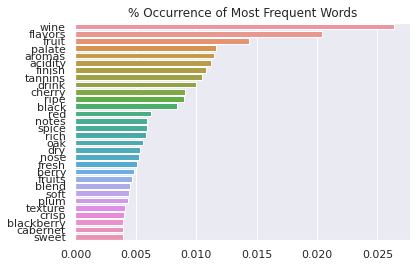

In [8]:
import seaborn as sns 
import matplotlib.pyplot as plt
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize
sns.set(style="darkgrid")
stopwords = set(stopwords.words('english'))
detokenizer = TreebankWordDetokenizer()
def clean_description(desc):
    desc = word_tokenize(desc.lower())
    desc = [token for token in desc if token not in stopwords and token.isalpha()]
    return detokenizer.detokenize(desc)
data["review_description"] = data["review_description"].apply(clean_description)
word_occurrence = data["review_description"].str.split(expand=True).stack().value_counts()
total_words = sum(word_occurrence)
top_words = word_occurrence[:30]/total_words
ax = sns.barplot(x = top_words.values, y = top_words.index)
ax.set_title("% Occurrence of Most Frequent Words")
plt.show()

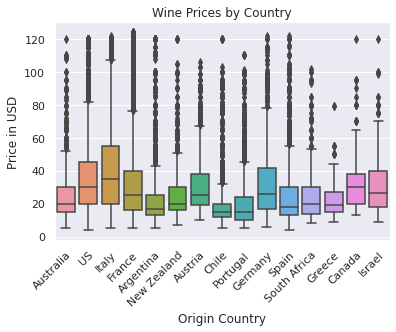

In [9]:
prices_by_country = data[["price", "country"]].dropna(how = "any")
val = prices_by_country["price"].quantile(0.98)
prices_by_country = prices_by_country[prices_by_country["price"] < val]
prices_by_country = prices_by_country.groupby("country").filter(lambda x: (x["price"].count() >= 100))
ax = sns.boxplot(x="country", y = "price", data=prices_by_country)
ax.set_title("Wine Prices by Country")
ax.set(xlabel = "Origin Country", ylabel = "Price in USD")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha="right",rotation_mode='anchor')
plt.show()

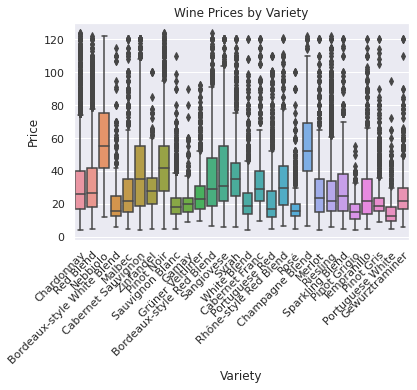

In [10]:
prices_by_variety = data[["price", "variety"]].dropna(how = "any")
val = prices_by_variety["price"].quantile(0.98)
prices_by_variety = prices_by_variety[prices_by_variety["price"] < val]
prices_by_variety = prices_by_variety.groupby("variety").filter(lambda x: (x["price"].count() >= 500))
ax = sns.boxplot(x="variety", y = "price", data=prices_by_variety)
ax.set_title("Wine Prices by Variety")
ax.set(xlabel = "Variety", ylabel = "Price")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha="right",rotation_mode='anchor')
plt.show()

In [11]:
data["variety"].value_counts()

Pinot Noir                    10587
Chardonnay                     9403
Cabernet Sauvignon             7552
Red Blend                      7166
Bordeaux-style Red Blend       5497
Riesling                       4148
Sauvignon Blanc                4011
Syrah                          3316
Rosé                           2831
Merlot                         2471
Nebbiolo                       2242
Zinfandel                      2209
Sangiovese                     2165
Malbec                         2119
Portuguese Red                 1969
White Blend                    1896
Sparkling Blend                1739
Tempranillo                    1448
Rhône-style Red Blend          1182
Pinot Gris                     1148
Champagne Blend                1133
Cabernet Franc                 1095
Grüner Veltliner               1055
Portuguese White                896
Pinot Grigio                    873
Bordeaux-style White Blend      850
Gewürztraminer                  840
Gamay                       

In [12]:
data.index

RangeIndex(start=0, stop=82657, step=1)

In [13]:
for index, row in data.iterrows():
  print(index)
  if row["region_1"] is np.nan or row["country"] is np.nan:
    data.drop(index,axis=0,inplace=True)
    print("dropped",index)
data=data.reset_index(drop=True)
data.index

Streaming output truncated to the last 5000 lines.
78302
78303
78304
78305
78306
dropped 78306
78307
78308
dropped 78308
78309
78310
78311
78312
78313
78314
78315
78316
78317
78318
78319
78320
78321
dropped 78321
78322
78323
78324
78325
78326
78327
78328
78329
78330
78331
78332
78333
78334
78335
78336
78337
78338
78339
78340
78341
78342
dropped 78342
78343
78344
78345
78346
78347
78348
78349
dropped 78349
78350
78351
78352
78353
78354
78355
78356
dropped 78356
78357
78358
78359
78360
78361
78362
78363
78364
78365
78366
78367
78368
78369
78370
78371
78372
78373
78374
dropped 78374
78375
78376
dropped 78376
78377
78378
78379
78380
dropped 78380
78381
78382
78383
78384
78385
78386
78387
78388
dropped 78388
78389
78390
78391
78392
78393
78394
78395
78396
78397
78398
78399
78400
78401
78402
78403
78404
78405
78406
78407
78408
78409
78410
78411
dropped 78411
78412
78413
dropped 78413
78414
dropped 78414
78415
dropped 78415
78416
dropped 78416
78417
78418
78419
78420
78421
78422
78423
78424
d

RangeIndex(start=0, stop=69903, step=1)

In [14]:
data

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery,variety
0,NaN,Australia,Andrew Peace 2007 Peace Family Vineyard Chardo...,classic chardonnay aromas apple pear hay lead ...,Peace Family Vineyard,83,10.0,Australia Other,South Eastern Australia,NaN,Andrew Peace,Chardonnay
1,@wawinereport,US,North by Northwest 2014 Red (Columbia Valley (...,wine near equal parts syrah merlot balance cab...,NaN,89,15.0,Washington,Columbia Valley (WA),Columbia Valley,North by Northwest,Red Blend
2,NaN,Italy,Renato Ratti 2007 Conca (Barolo),barolo conca opens inky dark concentration soo...,Conca,94,80.0,Piedmont,Barolo,NaN,Renato Ratti,Nebbiolo
3,@vossroger,France,Domaine l'Ancienne Cure 2010 L'Abbaye White (B...,impressive small addition sauvignon gris musca...,L'Abbaye,87,22.0,Southwest France,Bergerac Sec,NaN,Domaine l'Ancienne Cure,Bordeaux-style White Blend
4,@vossroger,France,Château du Cèdre 2012 Le Cèdre Vintage Malbec ...,ripe sweet wine rich full dried fresh fruit fl...,Le Cèdre Vintage,88,33.0,France Other,Vin de Liqueur,NaN,Château du Cèdre,Malbec
...,...,...,...,...,...,...,...,...,...,...,...,...
69898,@wineschach,Spain,Montecillo 2007 Crianza (Rioja),hot earth baked cherry mild vanilla aromas com...,Crianza,84,12.0,Northern Spain,Rioja,NaN,Montecillo,Tempranillo
69899,NaN,US,Vivác Winery 2008 Single Vineyard Cabernet Sau...,pungent notes turmeric dried flower hit nose f...,Single Vineyard,85,21.0,New Mexico,New Mexico,NaN,Vivác Winery,Cabernet Sauvignon
69900,@vossroger,France,Domaine de la Madone 2014 Nouveau (Beaujolais...,wine lively fruity weight structure well keepi...,Nouveau,87,14.0,Beaujolais,Beaujolais-Villages,NaN,Domaine de la Madone,Gamay
69901,@vossroger,France,Château Beaumont 2011 Haut-Médoc,impressive wine already shows signs potential ...,NaN,91,20.0,Bordeaux,Haut-Médoc,NaN,Château Beaumont,Bordeaux-style Red Blend


In [0]:
import random
storeind=list()
def reducetext(parme):
  for index, row in data.iterrows():
    flag=0
    stringtocom=data[parame][index].lower()
    words = stringtocom.split()
    num=0
    for word in words:
      for num in range(len(indivwords)):
        if word in indivwords[num]:
          storeind.append(num)
          flag=1
          break
        else:
          continue
      if flag==0:
        continue
      elif flag==1:
        break
    if flag==1:    
      continue
    if flag==0:
      storeind.append(random.randrange(0,len(indivwords)))
      continue
  return storeind  

In [16]:
parame='review_title'
data['revlist']=pd.DataFrame(reducetext(parame))
data['revlist']

0         0
1         1
2         3
3         3
4         4
         ..
69898     3
69899     5
69900    14
69901    27
69902     5
Name: revlist, Length: 69903, dtype: int64

In [17]:
!python -m nltk.downloader vader_lexicon
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from sklearn import preprocessing 
sia = SIA()
label_encoder = preprocessing.LabelEncoder() 
index=0
data['review_polarity']=0
savepol=list()
for index, row in data.iterrows():
  pol_score = sia.polarity_scores(data.iloc[index,3])
  savepol.append(pol_score['compound'])
  data['region_1'][index]=row['country'][:5]   

/usr/lib/python3.6/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [0]:
data['review_polarity']=pd.DataFrame(savepol)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


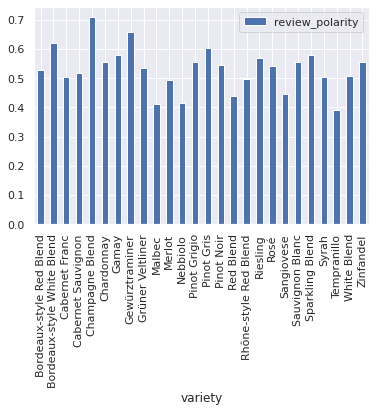

In [19]:
gk=pd.DataFrame(data, columns = ['variety','review_polarity','points','price'])
gk1 = gk.groupby('variety')['variety','review_polarity'].mean().reset_index().plot(kind='bar',x='variety',y='review_polarity')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


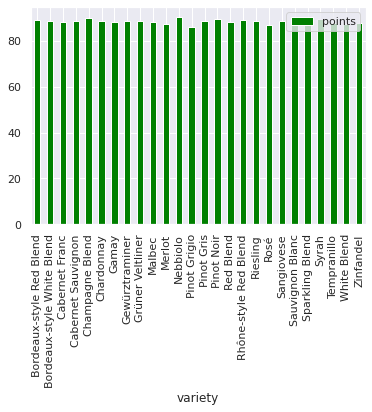

In [20]:
gk2 = gk.groupby('variety')['variety','points'].mean().reset_index().plot(kind='bar',x='variety',y='points',color="green")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


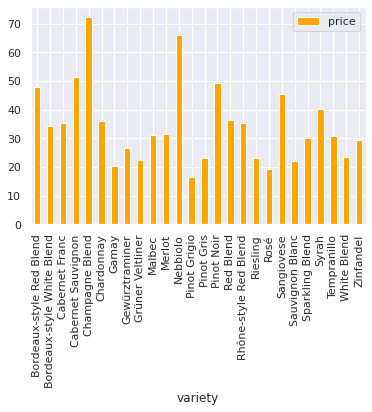

In [21]:
gk3 = gk.groupby('variety')['variety','price'].mean().reset_index().plot(kind='bar',x='variety',y='price',color='orange')

In [0]:
data['region_1']= label_encoder.fit_transform(data['region_1']) 
data['country']= label_encoder.fit_transform(data['country'])
data['province']= label_encoder.fit_transform(data['province']) 

In [23]:
data['country'].unique().size

7

In [24]:
data

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery,variety,revlist,review_polarity
0,NaN,1,Andrew Peace 2007 Peace Family Vineyard Chardo...,classic chardonnay aromas apple pear hay lead ...,Peace Family Vineyard,83,10.0,3,1,NaN,Andrew Peace,Chardonnay,0,0.4939
1,@wawinereport,6,North by Northwest 2014 Red (Columbia Valley (...,wine near equal parts syrah merlot balance cab...,NaN,89,15.0,60,6,Columbia Valley,North by Northwest,Red Blend,1,0.3400
2,NaN,4,Renato Ratti 2007 Conca (Barolo),barolo conca opens inky dark concentration soo...,Conca,94,80.0,44,4,NaN,Renato Ratti,Nebbiolo,3,0.3612
3,@vossroger,3,Domaine l'Ancienne Cure 2010 L'Abbaye White (B...,impressive small addition sauvignon gris musca...,L'Abbaye,87,22.0,51,3,NaN,Domaine l'Ancienne Cure,Bordeaux-style White Blend,3,0.5106
4,@vossroger,3,Château du Cèdre 2012 Le Cèdre Vintage Malbec ...,ripe sweet wine rich full dried fresh fruit fl...,Le Cèdre Vintage,88,33.0,15,3,NaN,Château du Cèdre,Malbec,4,0.9460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69898,@wineschach,5,Montecillo 2007 Crianza (Rioja),hot earth baked cherry mild vanilla aromas com...,Crianza,84,12.0,38,5,NaN,Montecillo,Tempranillo,3,0.0000
69899,NaN,6,Vivác Winery 2008 Single Vineyard Cabernet Sau...,pungent notes turmeric dried flower hit nose f...,Single Vineyard,85,21.0,33,6,NaN,Vivác Winery,Cabernet Sauvignon,5,0.0000
69900,@vossroger,3,Domaine de la Madone 2014 Nouveau (Beaujolais...,wine lively fruity weight structure well keepi...,Nouveau,87,14.0,4,3,NaN,Domaine de la Madone,Gamay,14,0.7845
69901,@vossroger,3,Château Beaumont 2011 Haut-Médoc,impressive wine already shows signs potential ...,NaN,91,20.0,5,3,NaN,Château Beaumont,Bordeaux-style Red Blend,27,0.8176


In [25]:
data['points'].shape

(69903,)

In [0]:
df = pd.DataFrame(data, columns = ['country', 'revlist', 'review_polarity', 'points', 'price', 'province','variety'])
df.dropna(how = "any",inplace=True)
df=df.reset_index(drop=True)
y=df['variety']
df = df.drop('variety', axis = 1)

In [27]:
df

,country,revlist,review_polarity,points,price,province
0,1,0,0.4939,83,10.0,3
1,6,1,0.3400,89,15.0,60
2,4,3,0.3612,94,80.0,44
3,3,3,0.5106,87,22.0,51
4,3,4,0.9460,88,33.0,15
...,...,...,...,...,...,...
65194,5,3,0.0000,84,12.0,38
65195,6,5,0.0000,85,21.0,33
65196,3,14,0.7845,87,14.0,4
65197,3,27,0.8176,91,20.0,5


In [0]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(df, y, test_size = 0.15)

In [29]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000, random_state=1,verbose=0.5)
train_features.shape,train_labels.shape
rf.fit(train_features, train_labels)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  1.3min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=1,
                       verbose=0.5, warm_start=False)

In [30]:
from sklearn import metrics
y_pred=rf.predict(test_features)
print("Accuracy:",metrics.accuracy_score(test_labels, y_pred))
y_pred

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy: 0.8388548057259714


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.9s finished


array(['Cabernet Sauvignon', 'Chardonnay', 'Bordeaux-style Red Blend',
       ..., 'Nebbiolo', 'Red Blend', 'Red Blend'], dtype=object)

In [0]:
testdata = pd.read_csv("./test.csv", index_col = False)
testdatacopy = pd.read_csv("./test.csv", index_col = False)
testdata["review_description"] = testdata["review_description"].apply(clean_description)      

In [32]:
testdata

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery
0,@paulgwine,US,Boedecker Cellars 2011 Athena Pinot Noir (Will...,nicely differentiated companion stewart bottli...,Athena,88,35.0,Oregon,Willamette Valley,Willamette Valley,Boedecker Cellars
1,@wineschach,Argentina,Mendoza Vineyards 2012 Gran Reserva by Richard...,charred smoky herbal aromas blackberry trend d...,Gran Reserva by Richard Bonvin,90,60.0,Mendoza Province,Mendoza,NaN,Mendoza Vineyards
2,@vboone,US,Prime 2013 Chardonnay (Coombsville),slightly sour funky earth restrained white age...,NaN,87,38.0,California,Coombsville,Napa,Prime
3,@wineschach,Argentina,Bodega Cuarto Dominio 2012 Chento Vineyard Sel...,concentrated malbec delivers aromatic goods fo...,Chento Vineyard Selection,91,20.0,Mendoza Province,Mendoza,NaN,Bodega Cuarto Dominio
4,@kerinokeefe,Italy,SassodiSole 2012 Brunello di Montalcino,earthy aromas suggesting grilled porcini leath...,NaN,90,49.0,Tuscany,Brunello di Montalcino,NaN,SassodiSole
...,...,...,...,...,...,...,...,...,...,...,...
20660,@gordone_cellars,US,Yorkville Cellars 2013 Rennie Vineyard Caberne...,clearly focused wine bonanza aromas concentrat...,Rennie Vineyard,91,34.0,California,Yorkville Highlands,North Coast,Yorkville Cellars
20661,@laurbuzz,France,Château Ribaute 2015 Senhal d'Aric Rosé (Corbi...,herbal tones bay rosemary upfront nose rosé gr...,Senhal d'Aric,84,20.0,Languedoc-Roussillon,Corbières,NaN,Château Ribaute
20662,@mattkettmann,US,Daou 2014 Reserve Cabernet Sauvignon (Paso Rob...,mocha cream pencil shaving dried herb aromas s...,Reserve,94,85.0,California,Paso Robles,Central Coast,Daou
20663,@wineschach,Spain,Peñascal 2011 Tempranillo Rosé (Vino de la Tie...,loud citrus berry aromas precede overloaded pa...,Tempranillo,80,9.0,Northern Spain,Vino de la Tierra de Castilla y León,NaN,Peñascal


In [0]:
testdata['country'].fillna('', inplace=True)
testdata['province'].fillna('', inplace=True)
testdata['points'].fillna(testdata['points'].mean(), inplace=True)
testdata['price'].fillna(testdata['price'].mean(), inplace=True)
testdata['country']= label_encoder.fit_transform(testdata['country'])
testdata['province']= label_encoder.fit_transform(testdata['province'])   

In [34]:
parame='review_title'
testdata['revlist']=pd.DataFrame(reducetext(parame))   
parame='review_description'
savepol1=list()
for index, row in testdata.iterrows():
  pol_score = sia.polarity_scores(testdata.iloc[index,3])
  savepol1.append(pol_score['compound'])
testdata['review_polarity']=pd.DataFrame(savepol1)    
preddf = pd.DataFrame(testdata, columns = ['country', 'revlist', 'review_polarity', 'points', 'price', 'province'])
testpred=rf.predict(preddf)
testdata['variety']=pd.DataFrame(testpred)
testdatacopy['variety']=pd.DataFrame(testpred)
testdatacopy.to_csv('Output-final.csv', header=True, index=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    6.3s finished


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


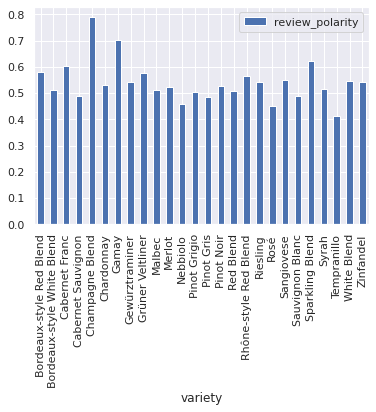

In [35]:
gktest=pd.DataFrame(testdata, columns = ['variety','review_polarity','points','price'])
gktest1 = gktest.groupby('variety')['variety','review_polarity'].mean().reset_index().plot(kind='bar',x='variety',y='review_polarity')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


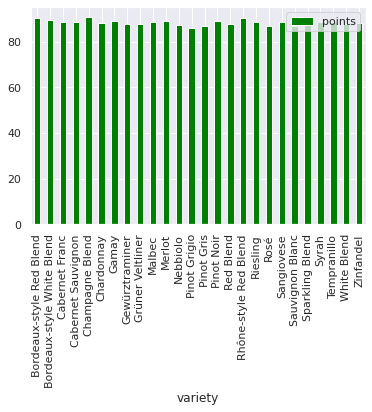

In [36]:
gktest2 = gktest.groupby('variety')['variety','points'].mean().reset_index().plot(kind='bar',x='variety',y='points',color='green')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


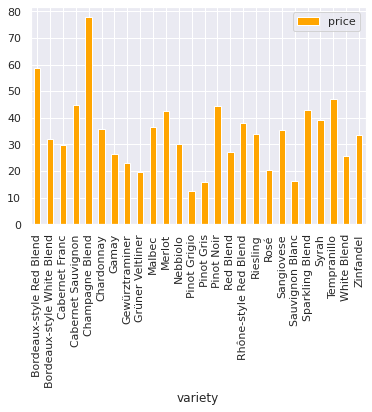

In [37]:
gktest3 = gktest.groupby('variety')['variety','price'].mean().reset_index().plot(kind='bar',x='variety',y='price',color='orange')